In [2]:
import glob
import os

from cartopy.crs import NorthPolarStereo
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib.tri import Triangulation

from tools import get_deformation_on_triangulation

In [3]:
d = dict(np.load('/data2/antonk/music/sa10free_P10C2_dev1/field_20070101T000000Z.npz'))

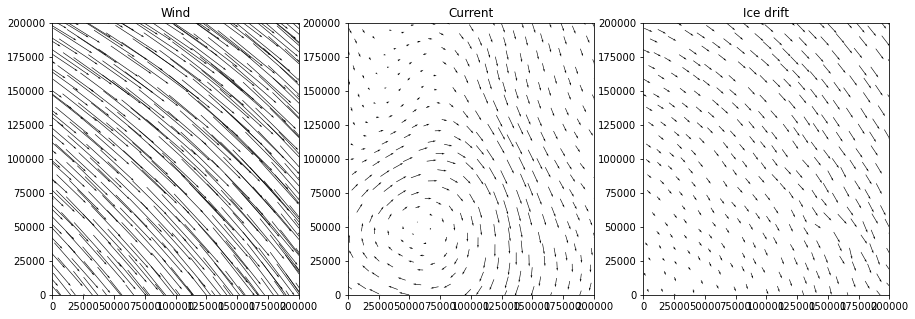

In [4]:
# plot vector variables
vec_vars = ['M_wind', 'M_ocean', 'M_VT']
scales = [20, 0.5, 1]
titles = ['Wind', 'Current', 'Ice drift']

xlim = [0, 200e3]
ylim = [0, 200e3]
fig, axs = plt.subplots(1,3, figsize=(15,5))
for ax, vec_var, scale, title in zip(axs, vec_vars, scales, titles):
    ax.quiver(d['x'], d['y'], d[vec_var][0], d[vec_var][1], scale=scale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
plt.show()

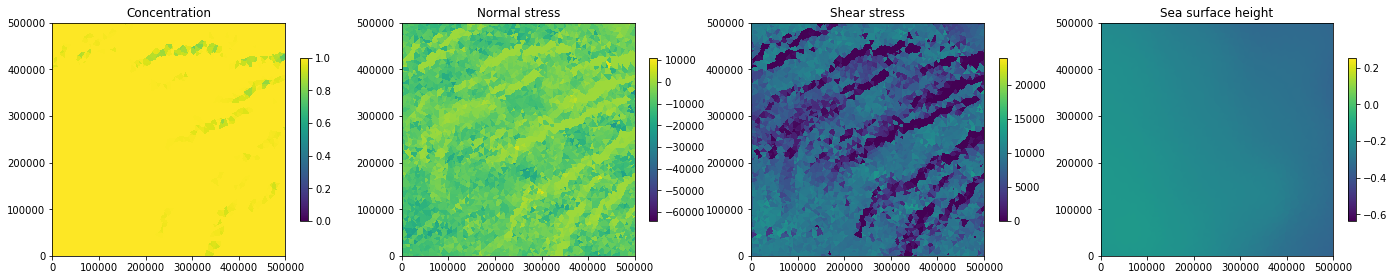

In [5]:
# plot some scalar variables
scal_vars = ['Concentration', 'Sigma_0', 'Sigma_1', 'M_ssh']
titles = ['Concentration', 'Normal stress', 'Shear stress', 'Sea surface height']

xlim = [0, 500e3]
ylim = [0, 500e3]
inches = 6
fig, axs = plt.subplots(1,len(scal_vars), figsize=(inches*len(scal_vars),inches))
for ax, scal_var, title in zip(axs, scal_vars, titles):
    trp = ax.tripcolor(d['x'], d['y'], d[scal_var], triangles=d['t'])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.colorbar(trp, ax=ax, shrink=0.5)
plt.show()

In [6]:
# get deformation in 1/sec, area and perimeter
e1, e2, e3, tri_a, tri_p = get_deformation_on_triangulation(d['x'], d['y'], d['M_VT'][0], d['M_VT'][1], d['t'])
# convert to 1/day
sec2day = 24*60*60
e1, e2, e3 = [i*sec2day for i in [e1, e2, e3]]

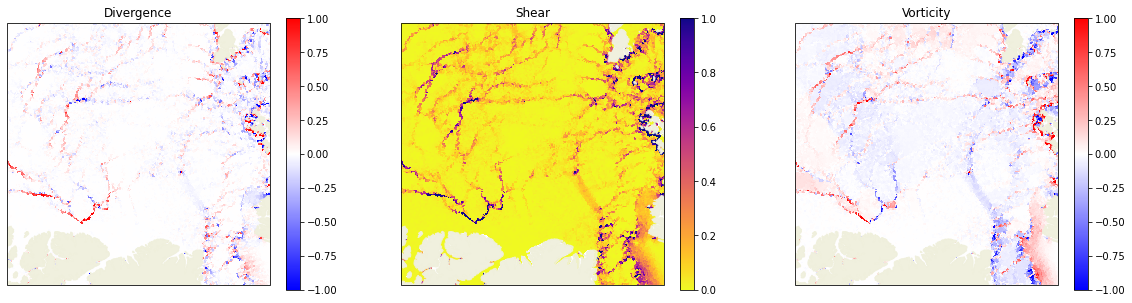

In [7]:
scal_vars = [e1, e2, e3]
titles = ['Divergence', 'Shear', 'Vorticity']
cmaps = ['bwr', 'plasma_r', 'bwr']
clims = [[-1,1], [0,1], [-1,1]]

xlim = [-1000e3, 1000e3]
ylim = [-1000e3, 1000e3]

srs_nextsim = NorthPolarStereo(central_longitude=-45, true_scale_latitude=60)

fig, axs = plt.subplots(1,3, figsize=(20,5), subplot_kw={'projection': srs_nextsim})
for ax, scal_var, title, cmap, clim in zip(axs, scal_vars, titles, cmaps, clims):
    trp = ax.tripcolor(d['x'], d['y'], scal_var, triangles=d['t'], cmap=cmap, vmin=clim[0], vmax=clim[1])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    plt.colorbar(trp, ax=ax)
    ax.add_feature(cfeature.LAND, zorder=1, alpha=0.9)
plt.show()

In [8]:
# interpolate scalar variables on a grid
# Define a grid in NorthPolarStereo projection
x_min = -1000e3
y_min = -1000e3
x_max = 1000e3
y_max = 1000e3
x_res = 10e3
y_res = 10e3
x_grd, y_grd = np.meshgrid(
    np.arange(x_min, x_max+x_res, x_res),
    np.arange(y_max, y_min-y_res, -y_res),
)

# get X, Y coordinates of elemn centers
x_elem = d['x'][d['t']].mean(axis=1)
y_elem = d['y'][d['t']].mean(axis=1)

# find border elements
t = Triangulation(d['x'], d['y'], d['t'])
less3neibs = np.where(np.any(t.neighbors == -1, axis=1))[0]

# replace border values with NaN
e2[less3neibs] = np.nan

# interpolate
shr_grd = griddata((x_elem, y_elem), e2, (x_grd, y_grd), method='nearest')


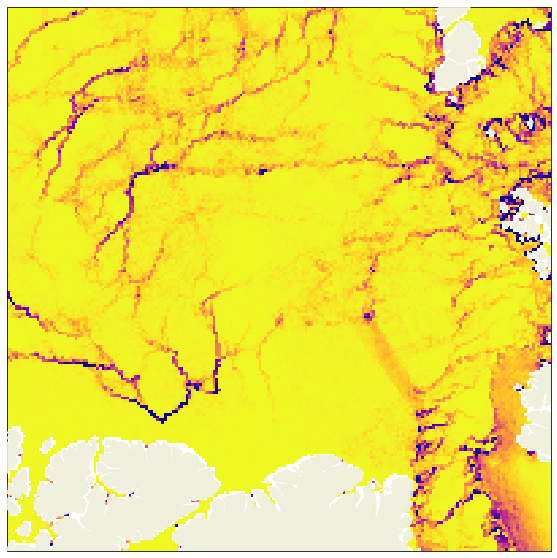

In [9]:
fig, axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection': srs_nextsim})
imsh = axs.imshow(shr_grd, cmap='plasma_r', clim=[0, 1], extent=[x_min, x_max, y_min, y_max], interpolation='nearest')
axs.set_xlim([x_min, x_max])
axs.set_ylim([y_min, y_max])
plt.colorbar(imsh, ax=ax)
axs.add_feature(cfeature.LAND, zorder=3, alpha=0.9)
plt.show()

In [10]:
"""
# How I saved the files. You don't need that...

def get_d_binary(ifile):
    from pynextsim import NextsimBin
    n = NextsimBin(ifile)
    bin_variables = [
        'M_wind',
        'M_ocean',
        'M_ssh',
        'M_VT',
        'Concentration',
        'Thickness',
        'Sigma_0',
        'Sigma_1',
        'Divergence',
        'Damage',
        'Concentration_young_ice',
    ]

    #['Elements', 'id', 'Nodes_x', 'Nodes_y']
    d = {}
    d['i'] = n.mesh_info.get_var('id')
    d['x'], d['y'], d['t'] = n.mesh_info.nodes_x, n.mesh_info.nodes_y, n.mesh_info.indices

    d['x'] = d['x'].astype('float32')
    d['y'] = d['y'].astype('float32')
    d['i'] = d['i'].astype('int32')
    d['t'] = d['t'].astype('int32')

    for bin_variable in bin_variables:
        d[bin_variable] = n.get_var(bin_variable).astype('float32')

    d['M_wind'] = d['M_wind'].reshape(2, -1)
    d['M_ocean'] = d['M_ocean'].reshape(2, -1)
    d['M_VT'] = d['M_VT'].reshape(2, -1)
    return d

idir = '/data2/antonk/music/sa10free_P10C2_dev0'
ifiles = sorted(glob.glob(f'{idir}/field*bin'))
for ifile in ifiles:
    ofile = ifile.replace('.bin', '.npz')
    if os.path.exists(ofile):
        continue
    print(ifile)
    d = get_d_binary(ifile)
    np.savez_compressed(ofile, **d)
    
#"""    

"\n# How I saved the files. You don't need that...\n\ndef get_d_binary(ifile):\n    from pynextsim import NextsimBin\n    n = NextsimBin(ifile)\n    bin_variables = [\n        'M_wind',\n        'M_ocean',\n        'M_ssh',\n        'M_VT',\n        'Concentration',\n        'Thickness',\n        'Sigma_0',\n        'Sigma_1',\n        'Divergence',\n        'Damage',\n        'Concentration_young_ice',\n    ]\n\n    #['Elements', 'id', 'Nodes_x', 'Nodes_y']\n    d = {}\n    d['i'] = n.mesh_info.get_var('id')\n    d['x'], d['y'], d['t'] = n.mesh_info.nodes_x, n.mesh_info.nodes_y, n.mesh_info.indices\n\n    d['x'] = d['x'].astype('float32')\n    d['y'] = d['y'].astype('float32')\n    d['i'] = d['i'].astype('int32')\n    d['t'] = d['t'].astype('int32')\n\n    for bin_variable in bin_variables:\n        d[bin_variable] = n.get_var(bin_variable).astype('float32')\n\n    d['M_wind'] = d['M_wind'].reshape(2, -1)\n    d['M_ocean'] = d['M_ocean'].reshape(2, -1)\n    d['M_VT'] = d['M_VT'].resha